In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

In [98]:
# The information is gathered from Steel company in South Korea to predict the energy consumption

# kWh is useful part that actually runs machines
# Reactive energy (kVarh): the magnetic or charging part that does not work but still flows in the wires


# Columns: 

# Lagging Current reactive power (kVarh), It is reactive energy from inductive stuff motors and transformers
# It does not do useful work but increases current and losses, it damages efficiency

# Leading Current reactive power (kVarh) corrects power factor
# It can cancel some lagging reactive energy and improve efficiency


# Lagging Current power factor is efficiency ratio when the load is inductive

# Leading Current power factor efficiency ratio when the load is capacitive

# tCO2(CO2), the carbon dioxide concentration measured around the process

# NSM: Number of Seconds from midnight, it shows daily patterns

# Load Type describes the plant's state.

# Week status: 0 for weekdays, 1 for weekends

# Source of DS: https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption
# To describe the features, I used Google and Grok.

<h1><center> Loading and Exploring</center><h1>


In [99]:
# Loading the data 
df = pd.read_csv("Steel_industry_data.csv")
df.head(10)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,01/01/2018 02:15,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load
9,01/01/2018 02:30,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load


In [100]:
# What I can see, timestamp is recorded every 15 minutes and the NSM shows 15 minutes
# I have 35040 columns in total and it can be divided by 4, which is 8760 hours
# 8760 can be divided by 24 hours, which is 365 days, so I have one year of data

In [101]:
# check the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [102]:
# It seems that there are no missing values in the DS.
# date, WeekStatus, Day of week and load type are object, I need to convert them to numerical foramt. 

In [103]:
# Let's check the duplicates in DS 
print('Duplicate rows:', df.duplicated().sum())

Duplicate rows: 0


In [104]:
# I realized that numerical columns have zero values, so let's find numbers of zero values in each column
zero_counts = (df == 0).sum().sort_values(ascending=False)
print('Account of zeros per numeric column:\n', (zero_counts/len(df)*100).round(2).astype(str) + '%')

Account of zeros per numeric column:
 Leading_Current_Reactive_Power_kVarh    67.38%
CO2(tCO2)                                59.9%
Lagging_Current_Reactive.Power_kVarh    20.53%
NSM                                      1.04%
Usage_kWh                                 0.0%
Lagging_Current_Power_Factor              0.0%
Leading_Current_Power_Factor              0.0%
date                                      0.0%
WeekStatus                                0.0%
Day_of_week                               0.0%
Load_Type                                 0.0%
dtype: object


In [105]:
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


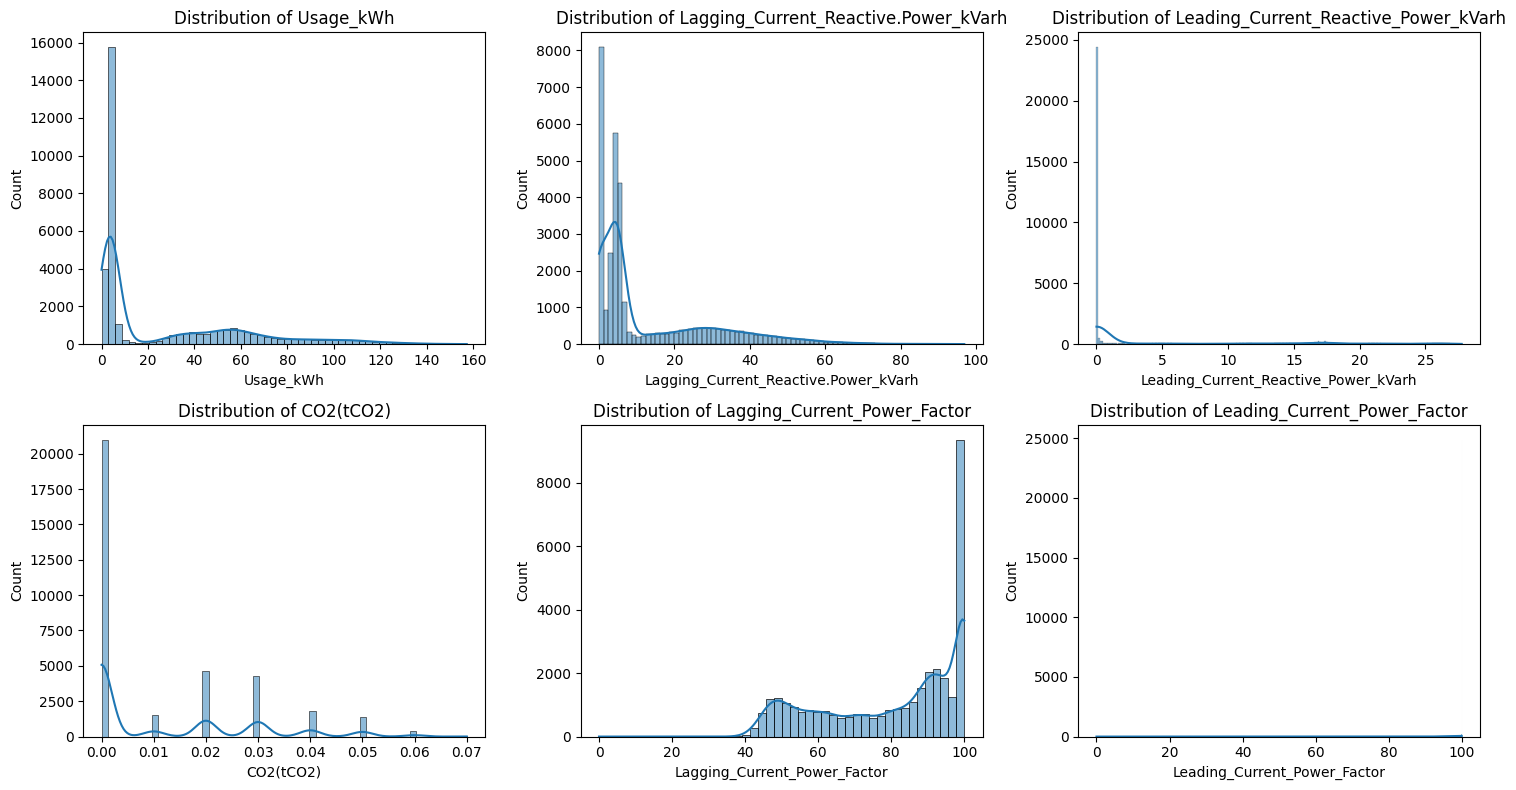

In [106]:
# Let's visualize the distribution of numeric columns
# In df.info() shows that numerical columns datatype is int64 and float 64
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
# I have 6 numeric columns, I need to create 2D grid of axes 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for column, ax in zip(numeric_columns, axes.ravel()):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Source: https://seaborn.pydata.org/generated/seaborn.objects.Bar.html
# For printing columns in 2 x 3 grid, I used Grok.

# What I can see 4 columns have right skewed distribution,
# Most values of energy consumption are close to 0, that means steel plant operates at low energy consumption
# lagging current reactive power's values are also close to 0, this makes sense because energy efficiency.
# Leading current reactive Power's has most right skewed distribution, which means the plant doesn't often need power factor correction.
# Lagging current power factor has left skewed distribution, which means that most of the time the plant operates with high efficiency
# Loading current power factor' values are at 100, which means when leading power factor is active, it's operating at maximum efficiency.

# For finding the meaning of these distributions, I used the Grok. 

In [107]:
# Converting the date column and extracting month, day
df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d/%m/%Y %H:%M')
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['quarter_15_min'] = df['date'].dt.minute // 15     

# The data is recorded at every 15 minutes, so I can convert NSM to minutes
# The DS is from 2018 so I dont need year
#df['Time_minutes'] = df['NSM'] / 60
df = df.drop(columns=['date', 'NSM'], axis=1)

In [108]:
df.head(15)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,WeekStatus,Day_of_week,Load_Type,month,day,hour,quarter_15_min
0,3.17,2.95,0.0,0.0,73.21,100.0,Weekday,Monday,Light_Load,1,1,0,1
1,4.00,4.46,0.0,0.0,66.77,100.0,Weekday,Monday,Light_Load,1,1,0,2
2,3.24,3.28,0.0,0.0,70.28,100.0,Weekday,Monday,Light_Load,1,1,0,3
3,3.31,3.56,0.0,0.0,68.09,100.0,Weekday,Monday,Light_Load,1,1,1,0
4,3.82,4.50,0.0,0.0,64.72,100.0,Weekday,Monday,Light_Load,1,1,1,1
5,3.28,3.56,0.0,0.0,67.76,100.0,Weekday,Monday,Light_Load,1,1,1,2
6,3.60,4.14,0.0,0.0,65.62,100.0,Weekday,Monday,Light_Load,1,1,1,3
7,3.60,4.28,0.0,0.0,64.37,100.0,Weekday,Monday,Light_Load,1,1,2,0
8,3.28,3.64,0.0,0.0,66.94,100.0,Weekday,Monday,Light_Load,1,1,2,1
9,3.78,4.72,0.0,0.0,62.51,100.0,Weekday,Monday,Light_Load,1,1,2,2


In [109]:
# Handling the categorical columns
categorical_features = ['Day_of_week', 'Load_Type']
# For avoiding the perfect multicollinearity, I am going to use drop first
df = pd.get_dummies(df, columns=categorical_features, dtype = int, drop_first=True)

In [110]:
# Label encoding
le = LabelEncoder()
df['WeekStatus'] = le.fit_transform(df['WeekStatus'])

# I will drop the sunday and saturday column because weekstatus presents same values
df.drop(['Day_of_week_Sunday', 'Day_of_week_Saturday'], axis=1, inplace=True)

In [111]:
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,WeekStatus,month,day,hour,quarter_15_min,Day_of_week_Monday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,3.17,2.95,0.0,0.0,73.21,100.0,0,1,1,0,1,1,0,0,0,0,0
1,4.00,4.46,0.0,0.0,66.77,100.0,0,1,1,0,2,1,0,0,0,0,0
2,3.24,3.28,0.0,0.0,70.28,100.0,0,1,1,0,3,1,0,0,0,0,0
3,3.31,3.56,0.0,0.0,68.09,100.0,0,1,1,1,0,1,0,0,0,0,0
4,3.82,4.50,0.0,0.0,64.72,100.0,0,1,1,1,1,1,0,0,0,0,0


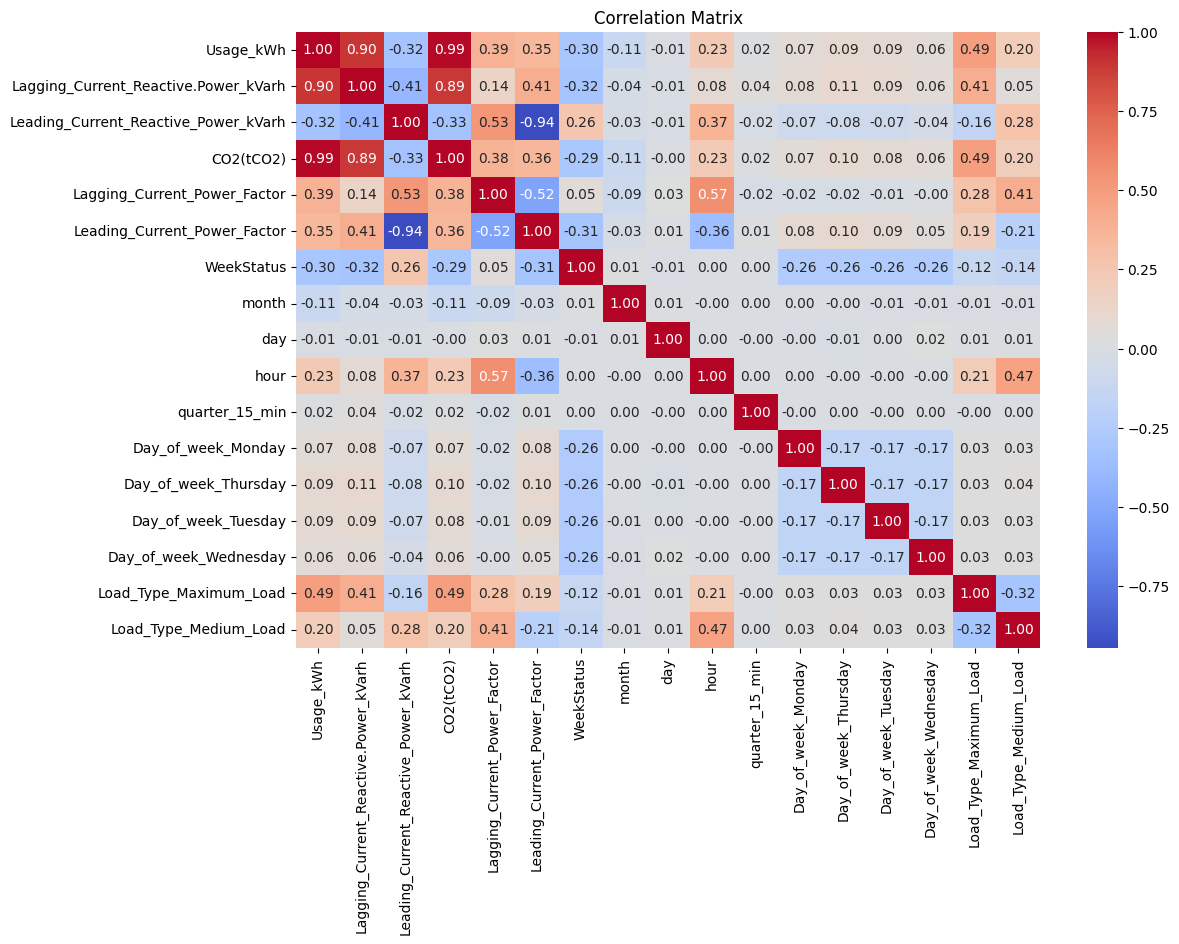

In [112]:
# correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [113]:
# Usage of energy has highest correlation with CO2, which make sense,  more energy = more CO2
# Lagging current reactive power also has high correlation with energy usage,  When the plant uses more energy, reactive power from motors also increases.
# Lagging current reactive power has high correlation with CO2, which makes sense, these two follow each other because both are linked to energy usage.

# Load current power factor has high negative correlation with leading current reactive power, this is completely expected.
# In few words, I can say that steel plant has reasonable relationships:
# more energy = more CO2 = more reactive power. The time columns do not show strong linear correlations.

# I am going to drop the CO2 column
df = df.drop('CO2(tCO2)', axis=1)

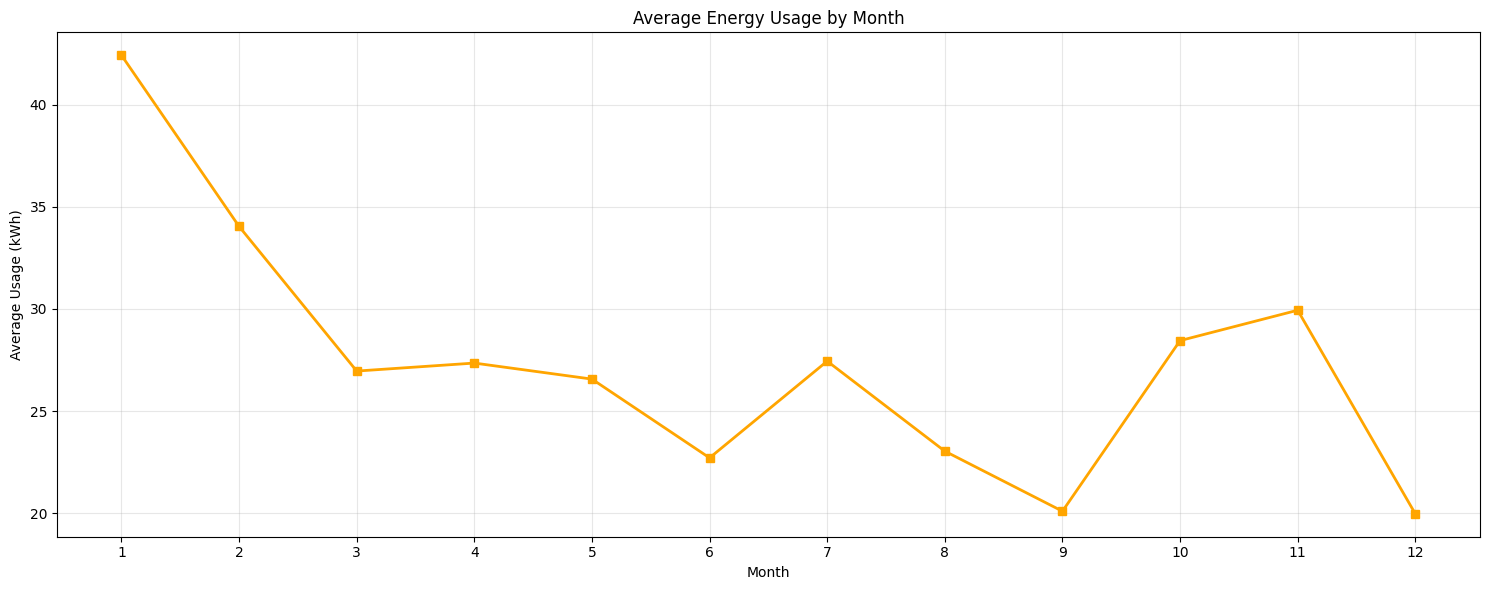

In [114]:
# Let's analyze energy usage month
monthly_usage = df.groupby('month')['Usage_kWh'].mean()
fig, (ax1) = plt.subplots(figsize=(15, 6))


# Monthly usage plot
ax1.plot(monthly_usage.index, monthly_usage.values, marker='s', color='orange', linewidth=2, markersize=6)
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Usage (kWh)')
ax1.set_title('Average Energy Usage by Month')
ax1.set_xticks(range(1, 13))
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Monthly usage goes down from 1st month to 3rd month, then it goes more down until 6th, this is because of the summer vocation.
# less energy is used at 9th month.

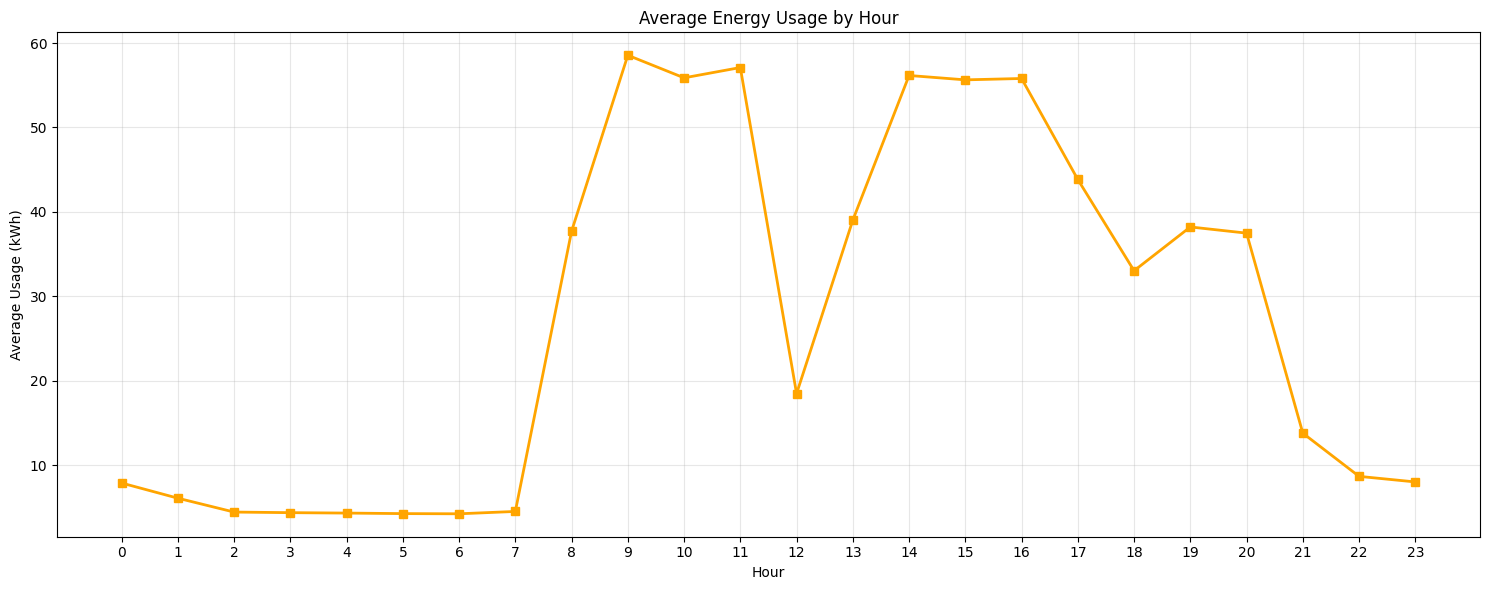

In [115]:
monthly_usage = df.groupby('hour')['Usage_kWh'].mean()
fig, (ax1) = plt.subplots(figsize=(15, 6))


# Monthly usage plot
ax1.plot(monthly_usage.index, monthly_usage.values, marker='s', color='orange', linewidth=2, markersize=6)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Usage (kWh)')
ax1.set_title('Average Energy Usage by Hour')
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
df.dtypes

date                                    datetime64[ns]
Usage_kWh                                      float64
Lagging_Current_Reactive.Power_kVarh           float64
Leading_Current_Reactive_Power_kVarh           float64
Lagging_Current_Power_Factor                   float64
Leading_Current_Power_Factor                   float64
NSM                                              int64
WeekStatus                                       int32
month                                            int32
day                                              int32
hour                                             int32
quarter_15_min                                   int32
Day_of_week_Monday                               int32
Day_of_week_Thursday                             int32
Day_of_week_Tuesday                              int32
Day_of_week_Wednesday                            int32
Load_Type_Maximum_Load                           int32
Load_Type_Medium_Load                            int32
dtype: obj

In [116]:
# Handling outliers
model = IsolationForest(n_estimators= 300, contamination= 0.25, random_state=42) 
model.fit(df)

df['outlier'] = model.predict(df)

# Creating mask for normal data 
# +1 is normal data 
# -1 is outlier
mask = df['outlier'] == 1
# Removing outliers by filtering with the mask
clean_df = df[mask]
clean_df = clean_df.drop('outlier', axis=1)

print("Original rows:", len(df))
print("Clean rows:", len(clean_df))
df = clean_df
# Source :https://www.digitalocean.com/community/tutorials/anomaly-detection-isolation-forest

Original rows: 35040
Clean rows: 26280


In [117]:
df.shape

(26280, 16)

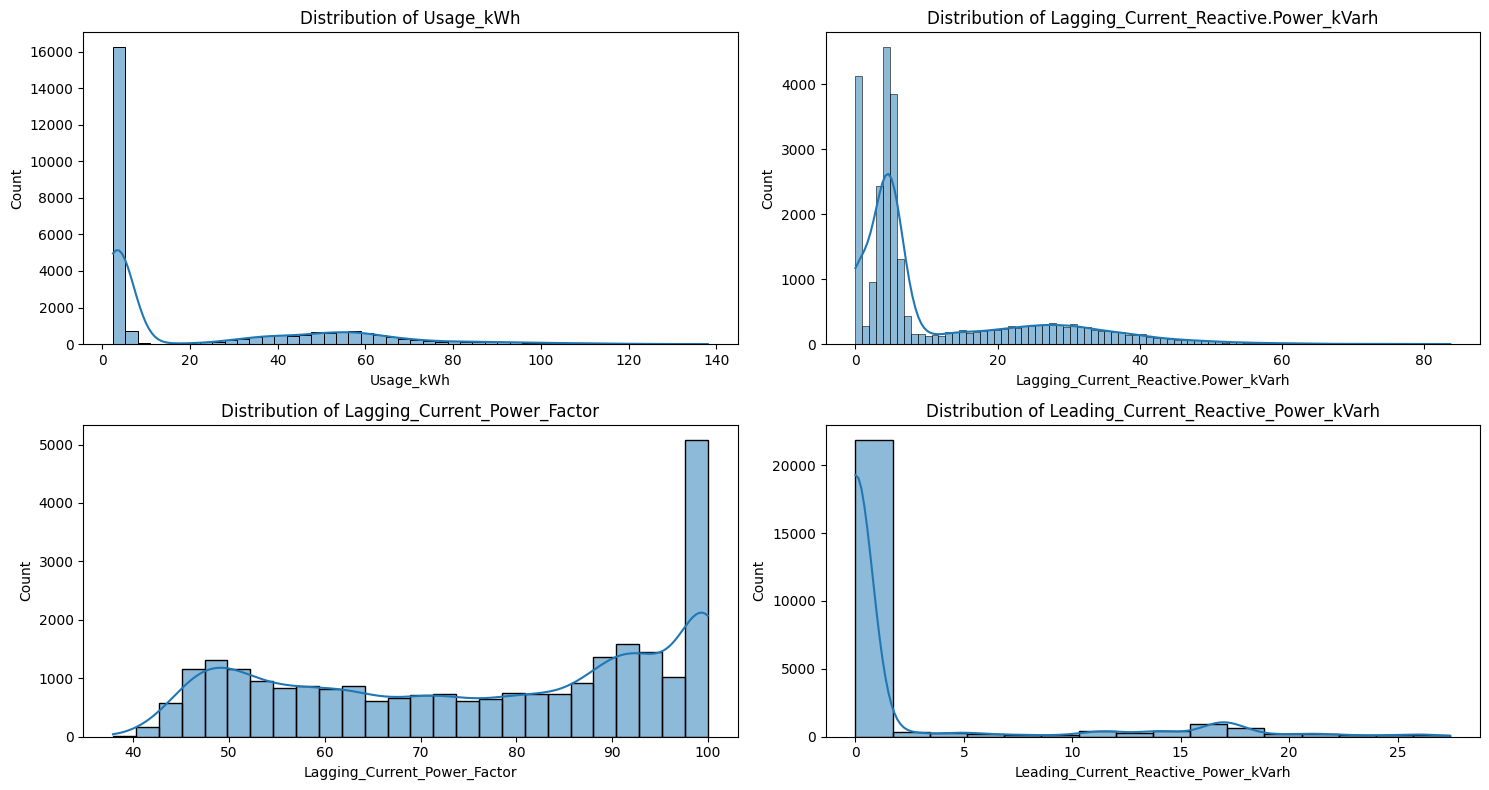

In [118]:
# Let's visualize the distributions after removing outliers
# I dont visualize the the leading current power factor, because values are at 100
numeric_columns = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 
            'Lagging_Current_Power_Factor', 'Leading_Current_Reactive_Power_kVarh']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
for column, ax in zip(numeric_columns, axes.ravel()):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

# Now the peak for each column, looks a bit more normal.

In [119]:
# VIF calculation for redundancy
vif_data = pd.DataFrame()
target = df.drop('Usage_kWh', axis=1)
vif_data["feature"] = target.columns
vif_data["VIF"] = [variance_inflation_factor(target.values, i) for i in range(len(target.columns))]
print(vif_data)
# I got the code structure from lecture note. 

                                 feature        VIF
0   Lagging_Current_Reactive.Power_kVarh   3.193372
1   Leading_Current_Reactive_Power_kVarh   6.331831
2           Lagging_Current_Power_Factor  36.820092
3           Leading_Current_Power_Factor  26.673934
4                             WeekStatus   3.267048
5                                  month   4.771435
6                                    day   4.392795
7                                   hour   5.795953
8                         quarter_15_min   2.913175
9                     Day_of_week_Monday   1.718359
10                  Day_of_week_Thursday   1.648047
11                   Day_of_week_Tuesday   1.685035
12                 Day_of_week_Wednesday   1.697106
13                Load_Type_Maximum_Load   2.487989
14                 Load_Type_Medium_Load   2.323623


In [120]:
# I am going to drop the Leading current power factor
df = df.drop(['Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor'] , axis=1) 

In [121]:
# Feature Selection with Random Forest Regressor
# Creating a Random Forest model  with 300 decision trees
X = df.drop('Usage_kWh', axis=1)
y = df['Usage_kWh'].values
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)


result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
print(importances)

Lagging_Current_Reactive.Power_kVarh    0.977685
hour                                    0.226955
Load_Type_Medium_Load                   0.164651
Load_Type_Maximum_Load                  0.132442
month                                   0.078760
day                                     0.031705
Leading_Current_Reactive_Power_kVarh    0.028307
WeekStatus                              0.014153
quarter_15_min                          0.003966
Day_of_week_Tuesday                     0.002620
Day_of_week_Monday                      0.002243
Day_of_week_Wednesday                   0.001548
Day_of_week_Thursday                    0.001238
dtype: float64


In [122]:
# Let's drop minute, Days of week
df = df.drop(['Day_of_week_Wednesday', 'Day_of_week_Thursday',
            'Day_of_week_Monday', 'Day_of_week_Tuesday', 'day', 'WeekStatus', 'quarter_15_min'] , axis=1)

In [125]:
"""
# Cyclical Time Features
# To capture cyclical nature of time
# Calculating total minutes of the day
total_minutes = 24 * 60
# Converting time to circle position 
time_radians = (2 * np.pi * df['Time_minutes']) / total_minutes
# Getting x and y coordinates
df['time_minutes_sin'] = np.sin(time_radians)
df['time_minutes_cos'] = np.cos(time_radians)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df = df.drop(columns=['Time_minutes', 'month'], axis=1)
# For the steel industry DS, ANN can understand that nighttime energy patterns flow smoothly into morning patterns.
# Source: https://medium.com/@axelazara6/why-we-need-encoding-cyclical-features-79ecc3531232
"""

"\n# Cyclical Time Features\n# To capture cyclical nature of time\n# Calculating total minutes of the day\ntotal_minutes = 24 * 60\n# Converting time to circle position \ntime_radians = (2 * np.pi * df['Time_minutes']) / total_minutes\n# Getting x and y coordinates\ndf['time_minutes_sin'] = np.sin(time_radians)\ndf['time_minutes_cos'] = np.cos(time_radians)\ndf['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)\ndf['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)\ndf = df.drop(columns=['Time_minutes', 'month'], axis=1)\n# For the steel industry DS, ANN can understand that nighttime energy patterns flow smoothly into morning patterns.\n# Source: https://medium.com/@axelazara6/why-we-need-encoding-cyclical-features-79ecc3531232\n"

In [126]:
# save the cleaned DS
df.to_csv('cleaned_data.csv', index=False)